<a href="https://colab.research.google.com/github/Dina-Essam/PoseEstimation/blob/master/PoseEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
import numpy as np
from scipy.ndimage import gaussian_filter, maximum_filter
import cv2
from keras.models import model_from_json

In [0]:
def loadModel(json, weights):
    json_file = open(json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(weights)  
    return loaded_model




def non_max_supression(plain, windowSize=3, threshold=1e-6):
    # clear value less than threshold
    under_th_indices = plain < threshold
    plain[under_th_indices] = 0
    return plain * (plain == maximum_filter(plain, footprint=np.ones((windowSize, windowSize))))

def render_joints(cvmat, joints, conf_th=0.01):
    for _joint in joints:
        _x, _y, _conf = _joint
        cv2.circle(cvmat, center=(int(_x), int(_y)), color=(0, 255, 0), radius=7, thickness=2)

    return cvmat

def post_process_heatmap(heatMap, kpConfidenceTh=0.2):
    kplst = list()
    for i in range(heatMap.shape[-1]): 
        # ignore last channel, background channel
        _map = heatMap[:, :, i]
        _map = gaussian_filter(_map, sigma=0.5)
        _nmsPeaks = non_max_supression(_map, windowSize=3, threshold=1e-6)

        y, x = np.where(_nmsPeaks == _nmsPeaks.max())
        if len(x) > 0 and len(y) > 0:
            kplst.append((int(x[0]), int(y[0]), _nmsPeaks[y[0], x[0]]))
        else:
            kplst.append((0, 0, 0))
    return kplst

def inference(img, loaded_model):
    #imgdata = cv2.imread(img)
    scale = (img.shape[0] * 1.0 / 256, img.shape[1] * 1.0 / 256)
    imgdata = cv2.resize(img, (256,256))
    
    mean = np.array([0.4404, 0.4440, 0.4327], dtype=np.float)
    imgdata = normalize(imgdata, mean)
    input = imgdata[np.newaxis, :, :, :]
    out = loaded_model.predict(input)
    return out[-1], scale
def normalize(imgdata, color_mean):

    imgdata = imgdata / 255.0

    for i in range(imgdata.shape[-1]):
        imgdata[:, :, i] -= color_mean[i]

    return imgdata


keys = ['r_ankle', 'r_knee', 'r_hip',
                'l_hip', 'l_knee', 'l_ankle',
                'plevis', 'thorax', 'upper_neck', 'head_top',
                'r_wrist', 'r_elbow', 'r_shoulder',
                'l_shoulder', 'l_elbow', 'l_wrist']


In [0]:
def get_output_layers(net):
    layer_names = net.getLayerNames()

    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers
def DetectPerson(image):
    Width = image.shape[1]
    Height = image.shape[0]
    scale = 0.00392

    net = cv2.dnn.readNet('./drive/My Drive/GP/yolov3.weights', './drive/My Drive/GP/yolov3.cfg')

    blob = cv2.dnn.blobFromImage(image, scale, (416, 416), (0, 0, 0), True, crop=False)

    net.setInput(blob)

    outs = net.forward(get_output_layers(net))

    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5 and class_id == 0:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])

    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    area = 0
    for i in indices:
        i = i[0]
        box = boxes[i]
        xtemp = box[0]
        ytemp = box[1]
        wtemp = box[2]
        htemp = box[3]
        areatemp = wtemp * htemp
        if (areatemp > area):
            area = areatemp
            x = xtemp
            y = ytemp
            w = wtemp
            h = htemp
    return x-50,y-75,w+50,h+50


In [0]:
###Predect 2D
def predict_2dpose(path_to_video,path_to_model,path_to_weights):
    model = loadModel(path_to_model,path_to_weights)

    cap = cv2.VideoCapture(path_to_video)
    body_cascade = cv2.CascadeClassifier('haarcascade_fullbody.xml')
    frame_joints=[]
    for gg in range(518):
        ret, frame = cap.read()
        if ret is False:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        x,y,w,h = DetectPerson(frame)
        crop_img = frame[round(y):round(y + h), round(x):round(x + w)]
        out, scale= inference(crop_img, model)
        keypoints = post_process_heatmap(out[0,:,:,:])
        joints=[]
        for _kp in keypoints:
            joints.append([_kp[0],_kp[1]])
        frame_joints.append(joints)
    cap.release()
    frame_joints = np.array(frame_joints)
    cv2.destroyAllWindows()
    frame_joints=frame_joints+[x,y]
    return frame_joints



In [0]:
import numpy as np
import copy
import tensorflow as tf
from tensorflow import keras
import pickle

# Stacked Hourglass produces 16 joints. These are the names.
SH_NAMES = ['']*16
SH_NAMES[0]  = 'RFoot'
SH_NAMES[1]  = 'RKnee'
SH_NAMES[2]  = 'RHip'
SH_NAMES[3]  = 'LHip'
SH_NAMES[4]  = 'LKnee'
SH_NAMES[5]  = 'LFoot'
SH_NAMES[6]  = 'Hip'
SH_NAMES[7]  = 'Spine'
SH_NAMES[8]  = 'Thorax'
SH_NAMES[9]  = 'Head'
SH_NAMES[10] = 'RWrist'
SH_NAMES[11] = 'RElbow'
SH_NAMES[12] = 'RShoulder'
SH_NAMES[13] = 'LShoulder'
SH_NAMES[14] = 'LElbow'
SH_NAMES[15] = 'LWrist'
# Joints in H3.6M -- data has 32 joints, but only 17 that move; these are the indices.
H36M_NAMES = ['']*32
H36M_NAMES[0]  = 'Hip'
H36M_NAMES[1]  = 'RHip'
H36M_NAMES[2]  = 'RKnee'
H36M_NAMES[3]  = 'RFoot'
H36M_NAMES[6]  = 'LHip'
H36M_NAMES[7]  = 'LKnee'
H36M_NAMES[8]  = 'LFoot'
H36M_NAMES[12] = 'Spine'
H36M_NAMES[13] = 'Thorax'
H36M_NAMES[14] = 'Neck/Nose'
H36M_NAMES[15] = 'Head'
H36M_NAMES[17] = 'LShoulder'
H36M_NAMES[18] = 'LElbow'
H36M_NAMES[19] = 'LWrist'
H36M_NAMES[25] = 'RShoulder'
H36M_NAMES[26] = 'RElbow'
H36M_NAMES[27] = 'RWrist'

In [0]:
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Add
from tensorflow.python.keras.layers.normalization import BatchNormalization
import numpy as np


def Linear_Model(X,drop):

    X = tf.keras.Input(shape=(32,))
    inp = X
    # First layer, brings dimensionality up to linear_size
    X = layers.Dense(1024, use_bias=True, kernel_initializer=tf.keras.initializers.he_normal(seed=None))(X)
    X = BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(drop)(X)

    X_shortcut = X
    # we can think of this chunk as the input layer
    X = layers.Dense(1024, use_bias=True, kernel_initializer=tf.keras.initializers.he_normal(seed=None))(X)
    X = BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(drop)(X)

    # we can think of this chunk as the hidden layer
    X = layers.Dense(1024, use_bias=True, kernel_initializer=tf.keras.initializers.he_normal(seed=None))(X)
    X = BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(drop)(X)

    # residual connection
    X = Add()([X, X_shortcut])

    X_shortcut = X
    # we can think of this chunk as the input layer
    X = layers.Dense(1024, use_bias=True, kernel_initializer=tf.keras.initializers.he_normal(seed=None))(X)
    X = BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(drop)(X)

    # we can think of this chunk as the hidden layer
    X = layers.Dense(1024, use_bias=True, kernel_initializer=tf.keras.initializers.he_normal(seed=None))(X)
    X = BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(drop)(X)

    # residual connection
    X = tf.keras.layers.Add()([X, X_shortcut])

    # Last Layer
    X = X = layers.Dense(42, use_bias=True, kernel_initializer=tf.keras.initializers.he_normal(seed=None))(X)
    predictions = layers.Activation('linear')(X)
    model = tf.keras.Model(inputs=inp, outputs=predictions)
    return model


In [0]:
def unNormalizeData(normalized_data, data_mean, data_std, dimensions_to_ignore):
  """
  Un-normalizes a matrix whose mean has been substracted and that has been divided by
  standard deviation. Some dimensions might also be missing
  Args
    normalized_data: nxd matrix to unnormalize
    data_mean: np vector with the mean of the data
    data_std: np vector with the standard deviation of the data
    dimensions_to_ignore: list of dimensions that were removed from the original data
  Returns
    orig_data: the input normalized_data, but unnormalized
  """
  T = normalized_data.shape[0] # Batch size
  D = data_mean.shape[0] # Dimensionality

  orig_data = np.zeros((T, D), dtype=np.float32)
  dimensions_to_use = np.array([dim for dim in range(D)
                                if dim not in dimensions_to_ignore])

  orig_data[:, dimensions_to_use] = normalized_data

  # Multiply times stdev and add the mean
  stdMat = data_std.reshape((1, D))
  stdMat = np.repeat(stdMat, T, axis=0)
  meanMat = data_mean.reshape((1, D))
  meanMat = np.repeat(meanMat, T, axis=0)
  orig_data = np.multiply(orig_data, stdMat) + meanMat
  return orig_data

In [0]:
def prediction3D(sh_2d,model_path):
    # PreProcessing
    #sh_2d=sh_2d.reshape(sh_2d.shape[:-2] + (-1,))#####(30,16,2)to(30,32)
    SH_TO_GT_PERM = np.array([SH_NAMES.index(h) for h in H36M_NAMES if h != '' and h in SH_NAMES])
    sh_2d = sh_2d[:, SH_TO_GT_PERM, :]
    # Reshape into n x (32*2) matrix
    sh_2d = np.reshape(sh_2d, [sh_2d.shape[0], -1])
    poses_final = np.zeros([sh_2d.shape[0], len(H36M_NAMES) * 2])
    dim_to_use_x = np.where(np.array([x != '' and x != 'Neck/Nose' for x in H36M_NAMES]))[0] * 2
    dim_to_use_y = dim_to_use_x + 1
    dim_to_use = np.zeros(len(SH_NAMES) * 2, dtype=np.int32)
    dim_to_use[0::2] = dim_to_use_x
    dim_to_use[1::2] = dim_to_use_y
    poses_final[:, dim_to_use] = sh_2d

    complete_train = copy.deepcopy(np.vstack(poses_final))
    data_mean = np.mean(complete_train, axis=0)
    data_std = np.std(complete_train, axis=0)
    dimensions_to_ignore=[]
    dimensions_to_use = np.where(np.array([x != '' and x != 'Neck/Nose' for x in H36M_NAMES]))[0]
    dimensions_to_use = np.sort(np.hstack((dimensions_to_use * 2, dimensions_to_use * 2 + 1)))
    dimensions_to_ignore = np.delete(np.arange(len(H36M_NAMES) * 2), dimensions_to_use)
    poses_final = poses_final[:, dimensions_to_use]
    mu = data_mean[dimensions_to_use]
    stddev = data_std[dimensions_to_use]
    encoder_inputs = np.divide((poses_final - mu), stddev)

    # Training
    model = Linear_Model(encoder_inputs, 0.5)#(30,32)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='mse',  # mean squared error
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    model=keras.models.load_model(model_path)
    predictions = model.predict(encoder_inputs)

    #PostProcessing
    enc_in = unNormalizeData(encoder_inputs, data_mean, data_std, dimensions_to_ignore)

    data_mean2 = np.load('./drive/My Drive/GP/weights/data_mean_3d.npy', allow_pickle=True)
    data_std2 = np.load('./drive/My Drive/GP/weights/data_std_3d.npy', allow_pickle=True)
    dimensions_to_ignore2 = np.load('./drive/My Drive/GP/weights/dim_to_ignore_3d.npy', allow_pickle=True)
    
    
    T = predictions.shape[0]  # Batch size
    D = 96  # Dimensionality
    orig_data = np.zeros((T, D), dtype=np.float32)
    dimensions_to_use = np.array([dim for dim in range(D) if dim not in dimensions_to_ignore2])
    orig_data[:, dimensions_to_use] = predictions
    # Multiply times stdev and add the mean
    stdMat = data_std2.reshape((1, D))
    stdMat = np.repeat(stdMat, T, axis=0)
    meanMat = data_mean2.reshape((1, D))
    meanMat = np.repeat(meanMat, T, axis=0)
    orig_data = np.multiply(orig_data, stdMat) + meanMat
    return orig_data,enc_in

In [0]:
def camera_to_world_frame(P, R, T):
  """Inverse of world_to_camera_frame
  Args
    P: Nx3 points in camera coordinates
    R: 3x3 Camera rotation matrix
    T: 3x1 Camera translation parameters
  Returns
    X_cam: Nx3 points in world coordinates
  """

  assert len(P.shape) == 2
  assert P.shape[1] == 3

  X_cam = R.T.dot( P.T ) + T # rotate and translate

  return X_cam.T

In [0]:
# Visualize random samples
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import cv2
import numpy as np
import h5py
import os
from mpl_toolkits.mplot3d import Axes3D

def Samples(poses3d,enc_in,videoPath):

    # 1080p	= 1,920 x 1,080
    fig = plt.figure( figsize=(19.2, 10.8) )

    gs1 = gridspec.GridSpec(1, 2) # 5 rows, 9 columns
    gs1.update(wspace=-0.00, hspace=0.05) # set the spacing between axes.
    plt.axis('off')
    cap = cv2.VideoCapture(videoPath)
    subplot_idx, exidx = 1, 1
    nsamples = poses3d.shape[0]-1
    for i in np.arange(nsamples/10):

        for a in range(10):
            ret, im = cap.read()
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        plt.subplot(gs1[subplot_idx - 1])
        plt.imshow(im)
        # Plot 2d predictions
        ax2 = plt.subplot(gs1[subplot_idx - 1])
        p2d = enc_in[exidx, :]
        show2Dpose(p2d, ax2)
        ax2.invert_yaxis()

        # Plot 3d predictions
        ax3 = plt.subplot(gs1[subplot_idx], projection='3d')
        p3d = poses3d[exidx,:]
        show3Dpose( p3d, ax3, lcolor="#9b59b6", rcolor="#2ecc71" )
        exidx = exidx+10
        plt.draw()
        plt.savefig('./drive/My Drive/GP/Demo/PIC'+str(i)+'.png')
        plt.pause(0.0001)
        plt.clf()


def showBB( bb ):
  # Visualize a bounding box.

  # bb = [xmin, ymin, xlen, ylen]
  assert bb.size == 4, "bb should have 4 entries"
  plt.plot([bb[0], bb[0]+bb[2]],[bb[1], bb[1]], lw=3, c='b')
  plt.plot([bb[0], bb[0]+bb[2]],[bb[1]+bb[3], bb[1]+bb[3]], lw=3, c='b')
  plt.plot([bb[0], bb[0]],[bb[1], bb[1]+bb[3]], lw=3, c='b')
  plt.plot([bb[0]+bb[2], bb[0]+bb[2]],[bb[1], bb[1]+bb[3]], lw=3, c='b')


class Ax3DPose(object):
    def __init__(self, ax, lcolor="#3498db", rcolor="#e74c3c"):
        ## REMOVE 15 from I and J
        self.I   = np.array([1,2,3,1,7,8,1, 13,14,15,14,18,19,14,26,27])-1
        self.J   = np.array([2,3,4,7,8,9,13,14,15,16,18,19,20,26,27,28])-1
        self.LR  = np.array([1,1,1,0,0,0,0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=bool)
        self.ax = ax

        vals = np.zeros((32, 3))
        ### 1 means right 0 means left
        # Make connection matrix
        self.plots = []
        for i in np.arange( len(self.I) ):
            x = np.array( [vals[self.I[i], 0], vals[self.J[i], 0]] )
            y = np.array( [vals[self.I[i], 1], vals[self.J[i], 1]] )
            z = np.array( [vals[self.I[i], 2], vals[self.J[i], 2]] )
            #self.plots.append(self.ax.plot(x, y, z, lw=2, c=lcolor if self.LR[i] else rcolor))
            self.plots.append(self.ax.plot(x, y, z, lw=2, c=lcolor if self.LR[i] else rcolor))
        self.ax.set_xlabel("x")
        self.ax.set_ylabel("y")
        self.ax.set_zlabel("z")

    def update(self, channels):
        assert channels.size == 96, "channels should have 96 entries, it has %d instead" % channels.size
        vals = np.reshape(channels, (32, -1))

        for i in np.arange( len(self.I) ):
            x = np.array( [vals[self.I[i], 0], vals[self.J[i], 0]] )
            y = np.array( [vals[self.I[i], 1], vals[self.J[i], 1]] )
            z = np.array( [vals[self.I[i], 2], vals[self.J[i], 2]] )
            self.plots[i][0].set_xdata(x)
            self.plots[i][0].set_ydata(y)
            self.plots[i][0].set_3d_properties(z)


        r = 750;
        xroot, yroot, zroot = vals[0,0], vals[0,1], vals[0,2]
        self.ax.set_xlim3d([-r+xroot, r+xroot])
        self.ax.set_zlim3d([-r+zroot, r+zroot])
        self.ax.set_ylim3d([-r+yroot, r+yroot])

        self.ax.set_aspect('equal')


def show3Dpose(channels, ax, lcolor="#3498db", rcolor="#e74c3c"): # blue, orange
  # Visualize a 3d skeleton.

  assert channels.size == 96, "channels should have 96 entries, it has %d instead" % channels.size
  vals = np.reshape( channels, (32, -1) )

  ## REMOVE 15 from I and J
  I   = np.array([1,2,3,1,7,8,1, 13,14,15,14,18,19,14,26,27])-1
  J   = np.array([2,3,4,7,8,9,13,14,15,16,18,19,20,26,27,28])-1
  LR  = np.array([1,1,1,0,0,0,0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=bool)
  # I  = np.array([1,2,3,1,7,8,1, 13,14,14,18,19,14,26,27])-1
  # J  = np.array([2,3,4,7,8,9,13,14,16,18,19,20,26,27,28])-1
  # LR = np.array([1,1,1,0,0,0,0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=bool)
  ### 1 means right 0 means left
  # Make connection matrix
  for i in np.arange( len(I) ):
    x = np.array( [vals[I[i], 0], vals[J[i], 0]] )
    y = np.array( [vals[I[i], 1], vals[J[i], 1]] )
    z = np.array( [vals[I[i], 2], vals[J[i], 2]] )
    ax.plot(x, y, z, lw=2, c=lcolor if LR[i] else rcolor)

  #print( vals[:,0] )
  # ax.scatter( vals[:,0], vals[:,1], vals[:,2], marker='o', s=8 )

  r = 750;
  xroot, yroot, zroot = vals[0,0], vals[0,1], vals[0,2]
  ax.set_xlim3d([-r+xroot, r+xroot]); ax.set_xlabel("x")
  ax.set_zlim3d([-r+zroot, r+zroot]); ax.set_ylabel("y")
  ax.set_ylim3d([-r+yroot, r+yroot]); ax.set_zlabel("z")
  #ax.view_init(elev=45., azim=0)

  # ax.get_xaxis().set_ticklabels([])
  # ax.get_yaxis().set_ticklabels([])
  # ax.set_zticklabels([])
  ax.set_aspect('equal')

def show2DposePrediction(channels, ax, lcolor="#3498db", rcolor="#e74c3c"):
  # Visualize a 2d skeleton.

  assert channels.size == 32, "channels should have 32 entries, it has %d instead" % channels.size
  vals = np.reshape( channels, (16, -1) )
  #I  = np.array([1,2,3,1,7,8,1, 13,14,15,14,18,19,14,26,27])-1
  #J  = np.array([2,3,4,7,8,9,13,14,15,16,18,19,20,26,27,28])-1

  """local pairRef = {
        {1,2},      {2,3},      {3,7},
        {4,5},      {4,7},      {5,6},
        {7,9},      {9,10},
        {14,9},     {11,12},    {12,13},
        {13,9},     {14,15},    {15,16}
    }
    local partNames = {'RAnk','RKne','RHip','LHip','LKne','LAnk',
                       'Pelv','Thrx','Neck','Head',
                       'RWri','RElb','RSho','LSho','LElb','LWri'}"""

  #I  = np.array([1,2,3,4,4,5,7,9, 14,11,12,13,14,15])-1
  #J  = np.array([2,3,7,5,7,6,9,10, 9,12,13, 9,15,16])-1
  #LR = np.array([0,0,0,1,1,1,0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=bool)
  I  = np.array([1,2,3,1,5,6,1,8, 9,9, 11,12,9, 14,15])-1
  J  = np.array([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])-1
  LR = np.array([1,1,1,0,0,0,0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=bool)
  ### 1 means right 0 means left
  # Make connection matrix
  #len(I)
  for i in np.arange(len(I)):
    x = np.array( [vals[I[i], 0], vals[J[i], 0]] )
    y = np.array( [vals[I[i], 1], vals[J[i], 1]] )
    ax.plot(x, y, lw=2, c=lcolor if LR[i] else rcolor)

  r = 350
  xroot, yroot = vals[0,0], vals[0,1]
  ax.set_xlim([-r+xroot, r+xroot]); ax.set_xlabel("x")
  ax.set_ylim([-r+yroot, r+yroot]); ax.set_ylabel("z")
  ax.set_aspect('equal')


class Ax2DPose(object):
    def __init__(self, ax, lcolor="#3498db", rcolor="#e74c3c"):
        vals = np.zeros((32, 2))
        self.ax = ax

        self.I  = np.array([1,2,3,1,7,8,1, 13,14,14,18,19,14,26,27])-1
        self.J  = np.array([2,3,4,7,8,9,13,14,16,18,19,20,26,27,28])-1
        self.LR = np.array([1,1,1,0,0,0,0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=bool)
        ### 1 means right 0 means left
        # Make connection matrix
        self.plots = []
        for i in np.arange( len(self.I) ):
          x = np.array( [vals[self.I[i], 0], vals[self.J[i], 0]] )
          y = np.array( [vals[self.I[i], 1], vals[self.J[i], 1]] )
          self.plots.append(self.ax.plot(x, y, lw=2, c=lcolor if self.LR[i] else rcolor))

        self.ax.set_aspect('equal')
        #self.ax.invert_yaxis()
        self.ax.set_ylabel("z")
        self.ax.set_xlabel("x")


    def update(self, im, channels):

        if not im:
            #print("Empty")
            pass
        elif not hasattr(self, 'im_data'):
            self.im_data = self.ax.imshow(im)
        else:
            self.im_data.set_data(im)

        assert channels.size == 64, "channels should have 64 entries, it has %d instead" % channels.size
        vals = np.reshape( channels, (32, -1) )


        # Make connection matrix
        for i in np.arange( len(self.I) ):
            x = np.array( [vals[self.I[i], 0], vals[self.J[i], 0]] )
            y = np.array( [vals[self.I[i], 1], vals[self.J[i], 1]] )
            self.plots[i][0].set_xdata(x)
            self.plots[i][0].set_ydata(y)

        r = 350
        xroot, yroot = vals[0,0], vals[0,1]
        self.ax.set_xlim([-r+xroot, r+xroot])
        self.ax.set_ylim([-r+yroot, r+yroot])
        self.ax.invert_yaxis()



def show2Dpose(channels, ax, lcolor="#3498db", rcolor="#e74c3c"):
  # Visualize a 2d skeleton.

  assert channels.size == 64, "channels should have 64 entries, it has %d instead" % channels.size
  vals = np.reshape( channels, (32, -1) )


  ## REMOVE 15 from I and J
  #  I  = np.array([1,2,3,1,7,8,1, 13,14,15,14,18,19,14,26,27])-1
  #  J  = np.array([2,3,4,7,8,9,13,14,15,16,18,19,20,26,27,28])-1
  #LR = np.array([1,1,1,0,0,0,0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=bool)
  I  = np.array([1,2,3,1,7,8,1, 13,14,14,18,19,14,26,27])-1
  J  = np.array([2,3,4,7,8,9,13,14,16,18,19,20,26,27,28])-1
  LR = np.array([1,1,1,0,0,0,0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=bool)
  ### 1 means right 0 means left
  # Make connection matrix
  for i in np.arange( len(I) ):
    x = np.array( [vals[I[i], 0], vals[J[i], 0]] )
    y = np.array( [vals[I[i], 1], vals[J[i], 1]] )
    ax.plot(x, y, lw=2, c=lcolor if LR[i] else rcolor)

  r = 350
  xroot, yroot = vals[0,0], vals[0,1]
  ax.set_xlim([-r+xroot, r+xroot]); ax.set_xlabel("x")
  ax.set_ylim([-r+yroot, r+yroot]); ax.set_ylabel("z")
  ax.set_aspect('equal')

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


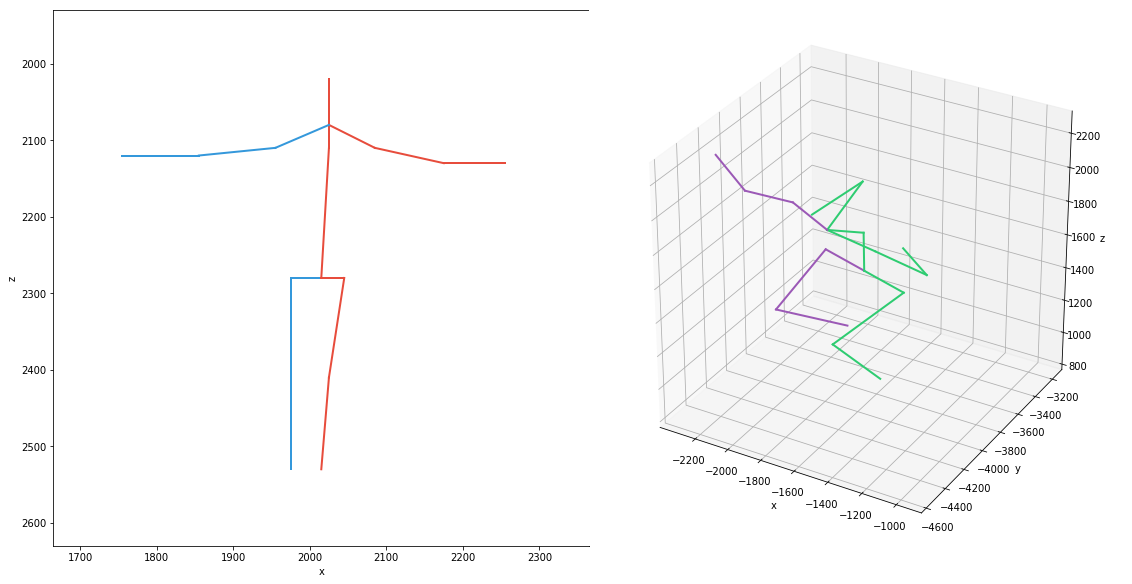

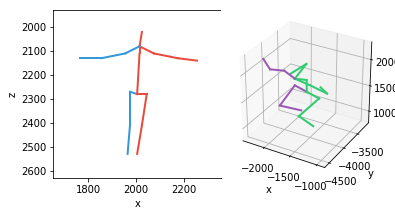

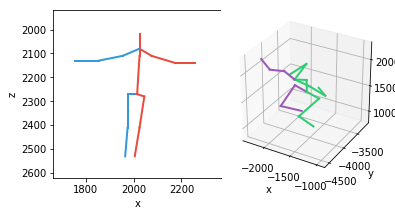

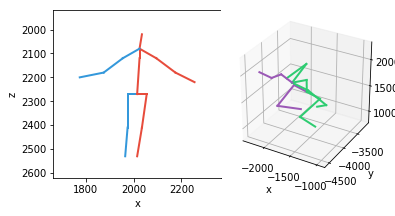

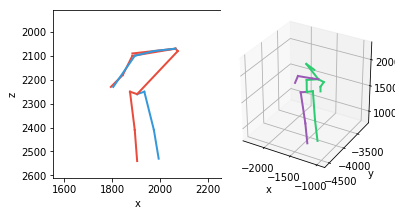

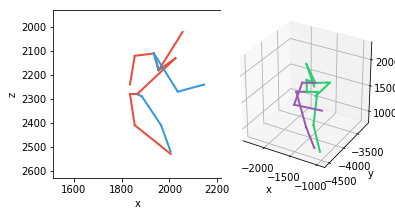

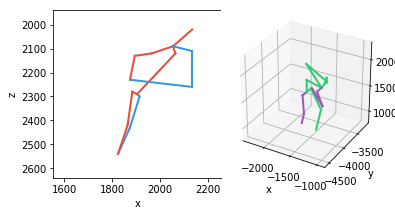

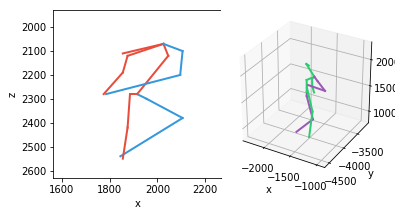

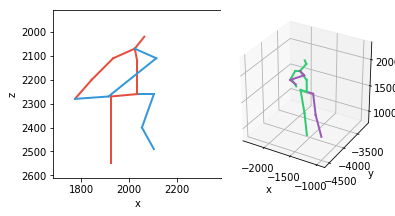

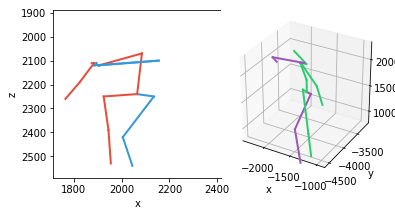

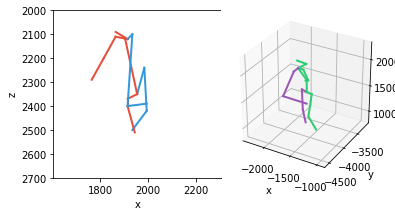

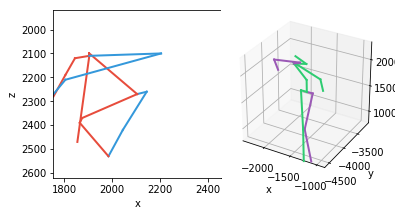

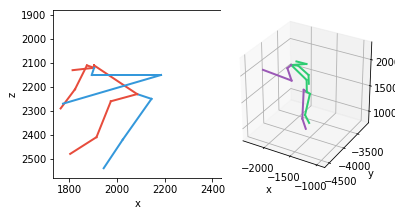

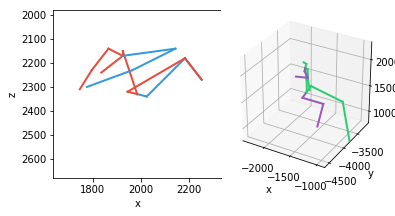

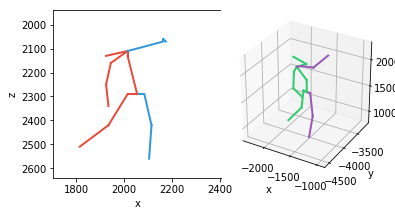

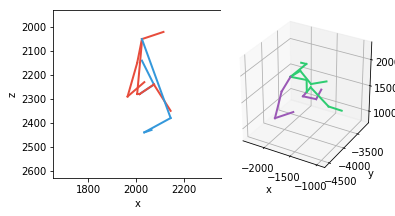

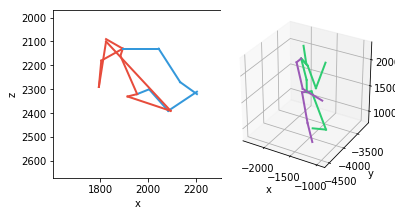

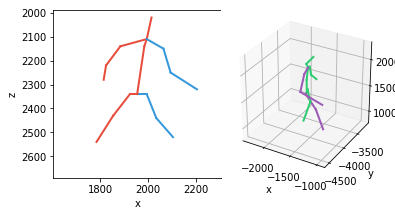

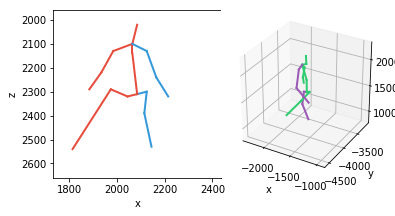

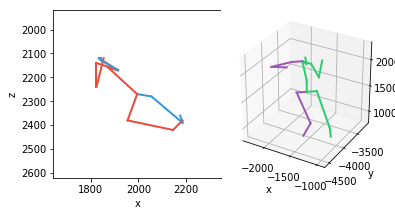

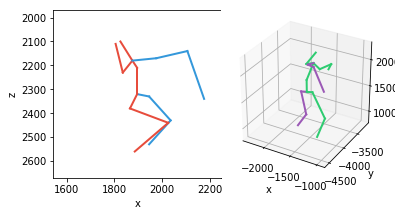

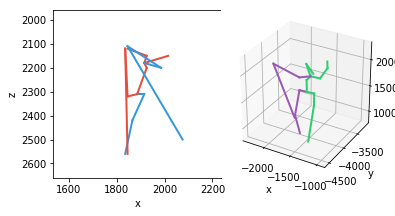

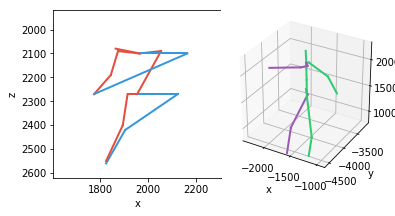

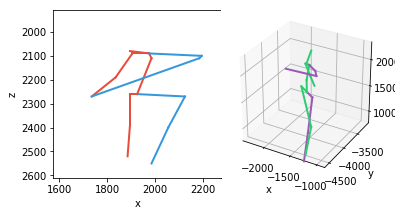

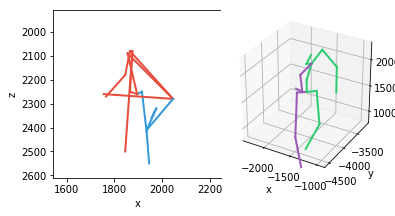

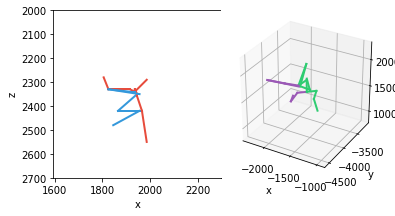

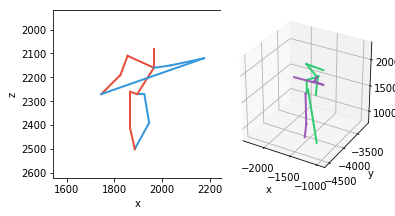

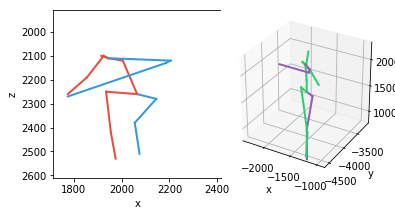

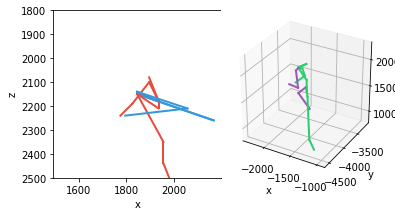

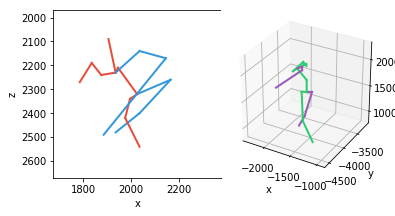

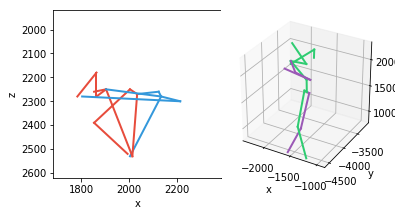

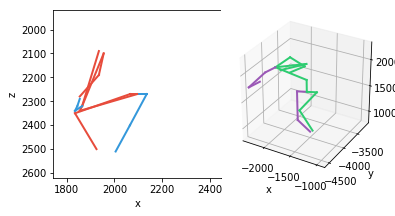

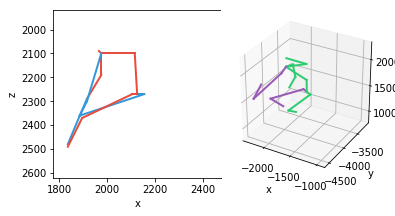

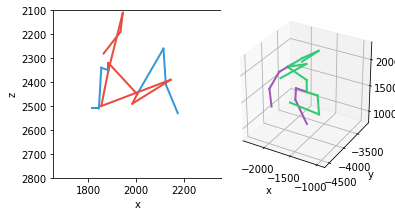

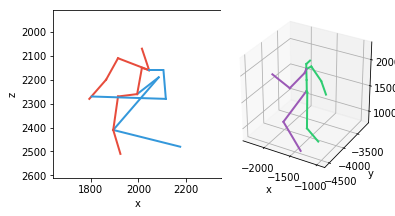

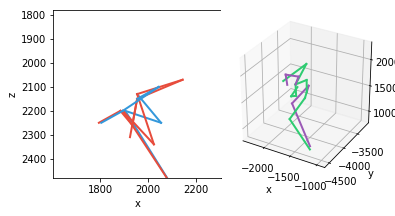

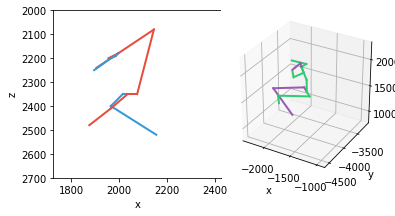

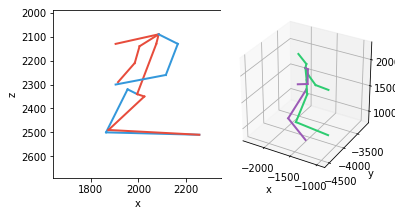

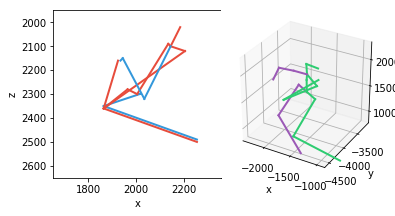

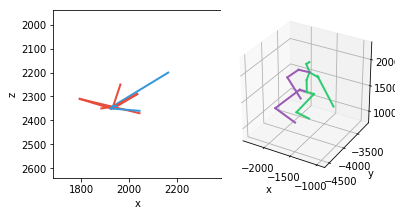

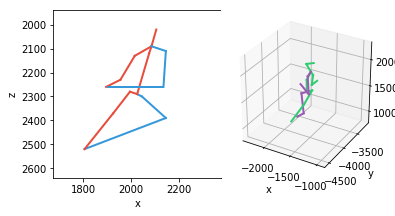

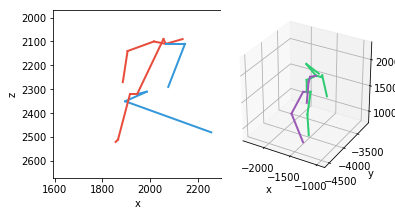

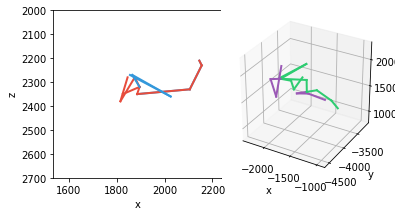

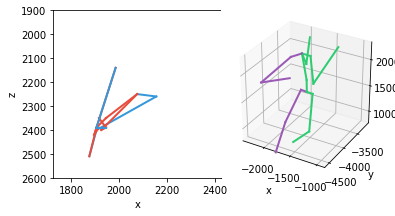

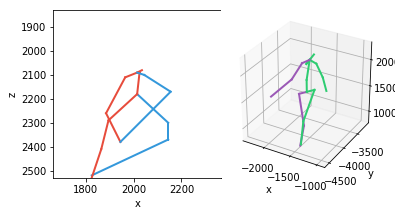

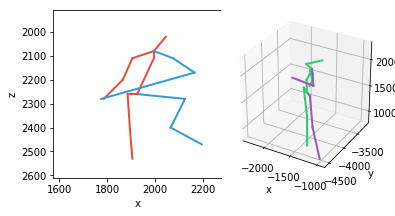

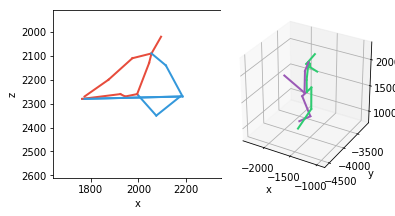

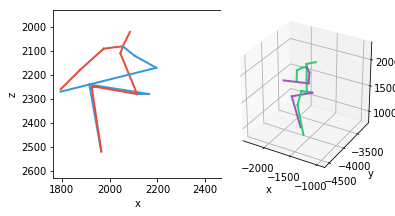

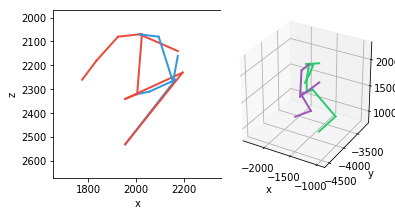

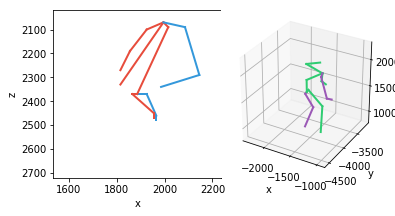

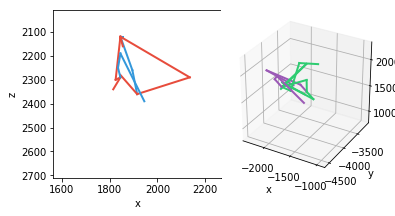

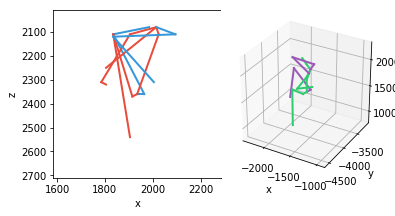

<Figure size 432x288 with 0 Axes>

In [28]:
from google.colab.patches import cv2_imshow

path_to_video='./drive/My Drive/GP/Walking.60457274.mp4'
path_to_model='./drive/My Drive/GP/data/data/net_arch.json'
path_to_weights='./drive/My Drive/GP/data/data/weights_epoch96.h5'
model_path3D="./drive/My Drive/GP/weights/my_Finalmodel64batch201epoch.tfl"

frame_joints= predict_2dpose(path_to_video,path_to_model,path_to_weights)

POINTS3D,POINTS2D = prediction3D(frame_joints,model_path3D)
import pickle
pickle_in = open("./drive/My Drive/weights/rcams.pickle", "rb")
rcams = pickle.load(pickle_in)
R, T, f, c, k, p, name = rcams[(5, 4)]

poses3d2 = camera_to_world_frame(POINTS3D.reshape((-1, 3)), R, T)
poses3d2 = poses3d2.reshape((-1, 32 * 3))
Samples(poses3d2,POINTS2D*10,path_to_video)


In [0]:
export_units = {}
for Frame in range(5):
  to_export = POINTS3D.tolist()[Frame]
  x,y,z = [[] for _ in range(3)]
  for o in range(0, len(to_export), 3):
      x.append(to_export[o])
      y.append(to_export[o+1])
      z.append(to_export[o+2])
  export_units[Frame]={}
  for jnt_index, (_x, _y, _z) in enumerate(zip(x,y,z)):
    export_units[Frame][jnt_index] = {"translate": [_x, _y, _z]}
print(export_units[4])

# Save JSON

In [0]:
File_path=""
with open(File_path, 'w') as outfile:
  logger.info("exported maya json to {0}".format(_out_file))
  json.dump(export_units, outfile)